In [158]:
import xarray as xr
import rioxarray as rx
import dask
import datacube

import matplotlib.pyplot as plt
from dask.distributed import Client

%matplotlib inline

In [30]:
# 384 hour forecasts for each time (16 * 24)
base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nforecast}&lev_{level}_mb=on&var_{component}=on&subregion=&leftlon={xmin}&rightlon={xmax}&toplat={ymin}&bottomlat={ymax}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"
url = base.format(date='20220301', time='00', nforecast='010', component='VGRD', level=975, xmin=100, xmax=160, ymin=1, ymax=-50)
url

'https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t00z.pgrb2.0p25.f010&lev_975_mb=on&var_VGRD=on&subregion=&leftlon=100&rightlon=160&toplat=1&bottomlat=-50&dir=%2Fgfs.20220301%2F00%2Fatmos'

In [31]:
name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(date='20220301', time='00', nf='010', comp='VGRD'.lower())
outdir = '/home/rvalavi/Downloads'
out = os.path.join(outdir, name)

out

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

In [32]:
wget.download(url, out)

-1 / unknown

'/home/rvalavi/Downloads/gfs_vgrd_20220301_t00z_f010'

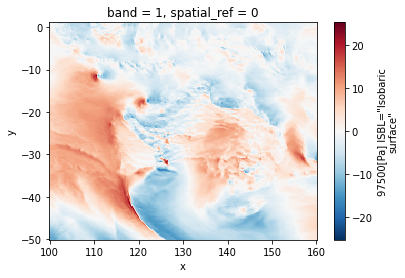

In [276]:
r = rx.open_rasterio(out)
r.plot()

In [114]:
# download GFS wind data
def download_wind(dates, time=12, nforecast=1, component='VGRD', level=975, outdir="", xmin=100, xmax=160, ymin=1, ymax=-50):
    import os, wget, sys
    # from tqdm import tqdm
    time = str(time).zfill(2) # convert to string and pad 0s if necessary
    if nforecast > 385:
        nforecast = 385
        print("'nforecast' cannot be higher than 385")
    if len(outdir) < 1:
        outdir = os.getcwd()
    if isinstance(dates, list):
        date = dates
    else:
        date = []
        date.append(dates)
    base = "https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl?file=gfs.t{time}z.pgrb2.0p25.f{nf}&lev_{level}_mb=on&var_{comp}=on&subregion=&leftlon={xn}&rightlon={xx}&toplat={yn}&bottomlat={yx}&dir=%2Fgfs.{date}%2F{time}%2Fatmos"       
    for i in date:
        for j in range(nforecast):
            nf = str(j).zfill(3) # convert to string and pad 0s if necessary
            name = "gfs_{comp}_{date}_t{time}z_f{nf}".format(comp=component.lower(), date=i, time=time, nf=nf)
            out = os.path.join(outdir, name)            
            url = base.format(date=i, time=time, nf=nf, comp=component.upper(), level=level, xn=xmin, xx=xmax, yn=ymin, yx=ymax)
            # write the file to disk
            wget.download(url, out)
            # print("nforcast", j, "downloaded!")
            

In [282]:
# download 2 days wind forecast
download_wind(dates=[20220301], time=00, nforecast=1, component='UGRD', outdir="/mnt/c/Users/61423/Desktop/GFStest/")

-1 / unknown

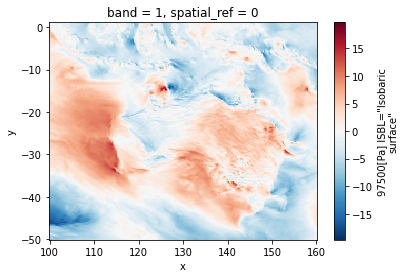

In [117]:
# read one of the files
r = rx.open_rasterio("/mnt/c/Users/61423/Desktop/GFStest/gfs_vgrd_20220227_t00z_f006")
r.plot()

In [130]:
r.dims

('band', 'y', 'x')

In [131]:
r.attrs

{'GRIB_COMMENT': 'v-component of wind [m/s]',
 'GRIB_DISCIPLINE': '0(Meteorological)',
 'GRIB_ELEMENT': 'VGRD',
 'GRIB_FORECAST_SECONDS': '21600 sec',
 'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2022-02-27T00:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
 'GRIB_PDS_PDTN': 0,
 'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '2 3 2 0 96 0 0 1 6 100 0 97500 255 0 0',
 'GRIB_PDS_TEMPLATE_NUMBERS': '2 3 2 0 96 0 0 0 1 0 0 0 6 100 0 0 1 124 220 255 0 0 0 0 0',
 'GRIB_REF_TIME': '1645920000 sec UTC',
 'GRIB_SHORT_NAME': '97500-ISBL',
 'GRIB_UNIT': '[m/s]',
 'GRIB_VALID_TIME': '1645941600 sec UTC',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'long_name': '97500[Pa] ISBL="Isobaric surface"'}

In [263]:
path = "/mnt/c/Users/61423/Desktop/GFStest/"
ls = os.listdir(path)
files = [os.path.join(path, i) for i in ls]

r1 = rx.open_rasterio(files[0], chunks=(1,1024,1024))

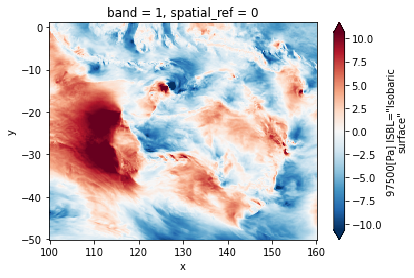

In [264]:
r1.plot(robust=True)

In [265]:
r2 = rx.open_rasterio(files[10], chunks=(1,1024,1024))
r2.dims

('band', 'y', 'x')

In [266]:
# r1 = r1.rename('0')
# r2 = r2.rename('1')
import numpy as np
import pandas as pd

rr2 = xr.concat([r1, r2], dim=pd.Index([0, 1], name='band'))

In [267]:
pd.Index([0, 1], name='band')

Int64Index([0, 1], dtype='int64', name='band')

In [268]:
rr2

<xarray.DataArray (band: 2, y: 205, x: 241)>
dask.array<concatenate, shape=(2, 205, 241), dtype=float64, chunksize=(1, 205, 241), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 0 1
  * x            (x) float64 100.0 100.2 100.5 100.8 ... 159.2 159.5 159.8 160.0
  * y            (y) float64 1.0 0.75 0.5 0.25 0.0 ... -49.25 -49.5 -49.75 -50.0
    spatial_ref  int64 0
Attributes:
    GRIB_COMMENT:                        v-component of wind [m/s]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        VGRD
    GRIB_FORECAST_SECONDS:               0 sec
    GRIB_IDS:                            CENTER=7(US-NCEP) SUBCENTER=0 MASTER...
    GRIB_PDS_PDTN:                       0
    GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES:  2 3 2 0 81 0 0 1 0 100 0 97500 255 0 0
    GRIB_PDS_TEMPLATE_NUMBERS:           2 3 2 0 81 0 0 0 1 0 0 0 0 100 0 0 1...
    GRIB_REF_TIME:                       1645920000 sec UTC
    GRIB_SHORT_NAME:                     97500-ISBL
    GRIB_UNIT:                           [m/s]
    GRIB_VALID_TIME:                     1645920000 sec UTC
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           97500[Pa] ISBL="Isobaric surface"

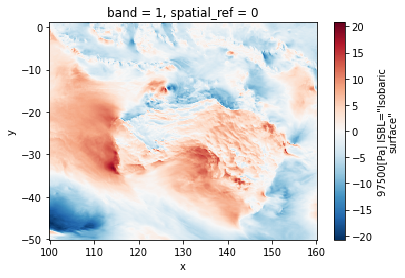

In [269]:
rr2[1].plot()

In [275]:
rr2[1].attrs

{'GRIB_COMMENT': 'v-component of wind [m/s]',
 'GRIB_DISCIPLINE': '0(Meteorological)',
 'GRIB_ELEMENT': 'VGRD',
 'GRIB_FORECAST_SECONDS': '0 sec',
 'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2022-02-27T00:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
 'GRIB_PDS_PDTN': 0,
 'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '2 3 2 0 81 0 0 1 0 100 0 97500 255 0 0',
 'GRIB_PDS_TEMPLATE_NUMBERS': '2 3 2 0 81 0 0 0 1 0 0 0 0 100 0 0 1 124 220 255 0 0 0 0 0',
 'GRIB_REF_TIME': '1645920000 sec UTC',
 'GRIB_SHORT_NAME': '97500-ISBL',
 'GRIB_UNIT': '[m/s]',
 'GRIB_VALID_TIME': '1645920000 sec UTC',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'long_name': '97500[Pa] ISBL="Isobaric surface"'}

In [274]:
r2.attrs

{'GRIB_COMMENT': 'v-component of wind [m/s]',
 'GRIB_DISCIPLINE': '0(Meteorological)',
 'GRIB_ELEMENT': 'VGRD',
 'GRIB_FORECAST_SECONDS': '36000 sec',
 'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2022-02-27T00:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
 'GRIB_PDS_PDTN': 0,
 'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '2 3 2 0 96 0 0 1 10 100 0 97500 255 0 0',
 'GRIB_PDS_TEMPLATE_NUMBERS': '2 3 2 0 96 0 0 0 1 0 0 0 10 100 0 0 1 124 220 255 0 0 0 0 0',
 'GRIB_REF_TIME': '1645920000 sec UTC',
 'GRIB_SHORT_NAME': '97500-ISBL',
 'GRIB_UNIT': '[m/s]',
 'GRIB_VALID_TIME': '1645956000 sec UTC',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'long_name': '97500[Pa] ISBL="Isobaric surface"'}

In [253]:
tt = rr2[1].attrs['GRIB_VALID_TIME']
tt

'1645920000 sec UTC'